# BlueSeer - Training, Quantization, and Export

In [ ]:
import os, io, time, copy

import sklearn
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import absl

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Remove Tensorflow C-level logging and warnings
tf.get_logger().setLevel('ERROR')
absl.logging.set_verbosity(absl.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Force font embedding when creating figure as PDF
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 1. Dataset

In [ ]:
train_set_path = "../dataset/train"
test_set_path = "../dataset/test"
output_path = "./constants_eval.cc"

base_path = "./"

MODELS_DIR = os.path.join(base_path, 'models')
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_CPP = MODELS_DIR + 'model.cc'

### Environment Category Labelling

In [3]:
# Combine subclasses from two different data collection periods into one common category bbreakdown
CLASS_MAPPING = {
        'street':'street',
        'park':'nature',
        'apartment':'home', 
        'supermarket':'shopping', 
        'clothing_store':'shopping', 
        'train':'transport', 
        'bus':'transport', 
        'gym':'entertainment', 
        'car':'transport', 
        'house':'home', 
        'nature':'nature', 
        'restaurant':'restaurant', 
        'cinema':'entertainment', 
        'concert':'entertainment', 
        'plane':'transport',
        'bar':'restaurant',
        'shopping':'shopping',
        'transport':'transport',
        'home':'home',
        'office':'office',
        'mensa':'restaurant',
        'lecture':'university', 
    }

def original_classes_to_blueseer_classes(Y_labels):
    mapping = CLASS_MAPPING.get
    return [mapping(label, label) for label in Y_labels]

### Parsing collected samples

In [4]:
# Find all paths to .CSV files
def find_csv_filenames(path_to_dir, suffix=".CSV"):
    filenames = []
    for sub in os.walk(path_to_dir):
        if sub[0] != path_to_dir:
            # find all .CSV files within the folder
            filenames += [sub[0] + "/" +
            filename for filename in os.listdir(sub[0]) if filename.endswith(suffix)]
    filenames.sort()
    return filenames


# Parse .CSV files into pandas Dataframes
def parse_files_to_df(files):
    dataframes = []
    for f in files:
        df = pd.read_csv(f)
        dataframes.append(df)
    return dataframes



#most common services in selected environments
SERVICES = [	"0af0", "1802", "180f", "1812", "1826", "2222", "ec88", "fd5a",
    "fd6f", "fdd2", "fddf", "fe03", "fe07", "fe0f", "fe61", "fe9f",
    "fea0", "feb9", "febe", "fee0", "ff0d", "ffc0", "ffe0"]

# features collected that are not used when creating the dataset
MUST_REMOVE_COLUMNS = [" services", " manufacturer_data_lengths",' time_point_1', ' time_point_2', ' time_point_3']

def process_files(dataframes,
                  without_services = False,
                  only_labels = None,
                  remove_columns = None,
                  verbose=False,
                 ):

    X_datapoints = []
    Y_labels = []
    available_columns = dataframes[0].columns.tolist()
    # remove label from columns
    available_columns.remove("label")
    # remove deprecated columns that might exist in the dataset
    for col in MUST_REMOVE_COLUMNS:
        try:
            available_columns.remove(col) # there must be a leading space!
        except Exception as e:
            #print(f"{col} not found in dataset")
            pass
    # remove any column we wish to get rid of
    if remove_columns is not None:
        for col in remove_columns:
            try:
                available_columns.remove(col) # there must be a leading space!
            except Exception as e:
                #print(f"{col} not found in dataset")
                pass
    # if we want to get rid of the 23most-common services, do so now
    if without_services:
        for serv in SERVICES:
            available_columns.remove(f" {serv}") # there is always a leading space!

    # for-each dataframe, add it to the dataset
    for df in dataframes:
        # Find label from first row
        label = df.iloc[0]["label"]
        X_datapoints.append(df[available_columns].to_numpy().flatten()) # .iloc[:num_scans-1]
        Y_labels.append(label)
    
    X_datapoints = np.array(X_datapoints)
    
    # Update classes to DAC classes
    Y_labels = original_classes_to_blueseer_classes(Y_labels)
    Y_labels = np.array(Y_labels)
    
    # Remove entertainment class & samples from dataset
    data_to_keep = Y_labels!='entertainment'#np.array([y!='entertainment' for y in Y_labels])
    X_datapoints = X_datapoints[data_to_keep]
    Y_labels = Y_labels[data_to_keep]
    Y_labels = list(Y_labels)
    Y_labels = np.array(Y_labels)
    # university
    data_to_keep = Y_labels!='university'#np.array([y!='entertainment' for y in Y_labels])
    X_datapoints = X_datapoints[data_to_keep]
    Y_labels = Y_labels[data_to_keep]
    Y_labels = list(Y_labels)

    # Check how many samples per environment where found
    unique_labels = set(Y_labels)
    if verbose:
        print(unique_labels)
        for lbl in unique_labels:
            print(f"{lbl}: {Y_labels.count(lbl)}")
    unique_labels = list(unique_labels)
    
    return X_datapoints, Y_labels, unique_labels, available_columns




### Data Normalization

In [5]:
# Z-score normalization: find Mean and Standard deviation of the distribution
def get_normalization_params(X):
    X = np.array(X)
    # Extract mean and std, per-feature
    feature_mean = np.nanmean(X,axis=0)
    feature_std = np.nanstd(X,axis=0)
    return feature_mean, feature_std

# X_normalized = (X - mean(X)) / STD(X)
def normalize_data(X,
                   Y_str,
                   feature_mean,
                   feature_std,
                   labels,
                   ):
    X = np.array(X)
    X = (X-feature_mean)/(feature_std+np.finfo(float).eps)
    # Transform Y data from string to integer
    Y = np.zeros((len(Y_str),))
    for i in range(len(Y_str)):
        Y[i] = labels.index(Y_str[i])
    Y = np.array(Y,dtype=np.int8)
    return X, Y

In [ ]:
# Generate C++ friendly representation of the normalization paramaters
# The function is called when generation the C++ code of BlueSeer
def generate_normalization_parameters_CPP(mean_list, std_list, labels):
    mean_str = "const float mean_list[] = {"
    for i in range(0, len(mean_list)):
        if i != 0:
            mean_str += ", "
        mean_str += str(mean_list[i])
    mean_str += "};"
    
    std_str = "const float std_list[] = {"
    for i in range(0, len(std_list)):
        if i != 0:
            std_str += ", "
        std_str += str(std_list[i])
    std_str += "};"

    labels_str = "const char available_env[][16] = {"
    for i in range(0, len(labels)):
        if i != 0:
            labels_str += ", "
        labels_str += "\""+labels[i]+"\""
    labels_str += "};"
    return mean_str, std_str, labels_str

### Class Equalization

In [ ]:
def equalize_class_distribution(X, Y, remove_class=[]):
    # Separate each class instance into bins
    classes = list(np.unique(Y))
    try:
        classes.remove(remove_class)
    except Exception as e:
        pass
    per_class_X = dict()
    smallest_class = 999999
    for cls in classes:
        per_class_X[cls] = X[Y==cls]
        smallest_class = per_class_X[cls].shape[0] if per_class_X[cls].shape[0] < smallest_class else smallest_class
    # Shuffle data, keep an equal number of instances per class
    for cls in classes:
        np.random.shuffle(per_class_X[cls])
        per_class_X[cls] = per_class_X[cls][:smallest_class]
    # recombine into one array
    X_new = np.concatenate([per_class_X[cls] for cls in classes], axis=0)
    Y_new = np.array([cls for cls in classes for i in range(smallest_class)])
    return X_new, Y_new

### Dataset Preparation

In [6]:
def prepare_datasets(training_path,
                     eval_path,
                     without_services=True,
                     verbose=False,
                    ):
    if verbose:
        print("Loading training data...")
    train_dataframes = parse_files_to_df(find_csv_filenames(training_path))
    if verbose:
        print("Loading eval data...")
    eval_dataframes = parse_files_to_df(find_csv_filenames(eval_path))
    if verbose:
        print(f"Training set: {len(train_dataframes)} samples")
        print(f"Eval set: {len(eval_dataframes)} samples")

    if verbose:
        print("Manipulating training data...")
    X_train, Y_train, labels, features = process_files(train_dataframes,
                                                         without_services=without_services,
                                                         verbose=verbose,
                                                        )
    # get per-feature normalization (mean and std)
    feature_mean, feature_std = get_normalization_params(X=X_train)
    # normalize dataset
    X_train, Y_train = normalize_data(X_train,
                                          Y_train,
                                          feature_mean,
                                          feature_std,
                                          labels)
    if verbose:
        print("Manipulating eval data...")
    X_eval, Y_eval, _, _ = process_files(eval_dataframes,
                                         only_labels = labels,
                                         without_services=without_services,
                                         verbose=verbose,
                                        )
    X_eval, Y_eval = normalize_data(X_eval,
                                        Y_eval,
                                        feature_mean,
                                        feature_std,
                                        labels
                                       )
    
    # equalizing eval dataset
    print("equalizing Eval set (all classes have the same number of samples, based on the smallest class)")
    X_eval,Y_eval = equalize_class_distribution(X_eval, Y_eval)
    
    prepared = dict()
    prepared['training'] = (X_train, Y_train)
    prepared['eval'] = (X_eval, Y_eval)
    prepared['feature_mean'] = feature_mean
    prepared['feature_std'] = feature_std
    prepared['labels'] = labels
    prepared['features'] = features
    
    return prepared

# Divide training dataset into train and test sets
def split_training_set(X_train, Y_train):
    return X_train, Y_train, None, None

# 2. BlueSeer Neural Network Model

In [ ]:
def get_BlueSeer_model(num_classes, input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=500,input_shape=input_shape,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-5),name="layer0_dense"))
    model.add(tf.keras.layers.Dropout(0.5,name="layer0_dropout"))
#     model.add(tf.keras.layers.Dense(units=500,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-5),name="layer1_dense"))
#     model.add(tf.keras.layers.Dropout(0.5,name="layer1_dropout"))
    model.add(tf.keras.layers.Dense(units=num_classes,activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(1e-5),name="layer2_class_output"))
    return model

# layer is an array containing the number of neurons per Dense layer
# example: layers=[250,250] creates a NN with two hidden Dense layers with 250 neurons each
# We add a dropout with p=0.5 after every layer
def get_varying_size_BlueSeer_model(num_classes, layers):
    model = tf.keras.Sequential()
    for num_neurons in layers:
        model.add(tf.keras.layers.Dense(units=num_neurons,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(units=num_classes,activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
    return model


# learning Rate decay
def lr_scheduler(epoch, lr):
    if epoch < 4:
        return 0.01
    else:
        return lr * tf.math.exp(-0.1)


def get_smallest_model(num_classes, input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=num_classes,input_shape=input_shape,activation="softmax",kernel_regularizer=tf.keras.regularizers.l2(1e-5),name="layer2_class_output"))
    return model


# 3. Training

In [ ]:
prepared = prepare_datasets(train_set_path, test_set_path, without_services=True, verbose=True)

(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
feature_std = np.maximum(feature_std, 1.0)
features = prepared['features']

In [ ]:
best_model = None
best_acc = 0.0
for i in range(10):
    # Create test split
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)
    # Create and eval model
    model,acc, _, _ = eval_model(X_train,
               Y_train,
               X_val,
               Y_val,
               X_eval,
               Y_eval,
               labels,
               feature_mean,
               feature_std,
               features,
               verbose=0,
               quantize_model=True,
              )
    if acc > best_acc:
        best_model = model

# 4. Model Conversion

In [ ]:
def convert_model(original_model, X_train):
    converter = tf.lite.TFLiteConverter.from_keras_model(original_model)
    # Set the optimization flag
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Enforce integer only quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    # We keep float for input and output
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.float32
    # Provide a representative dataset to ensure we quantize correctly
    def representative_dataset():
        for i in range(len(X_train)):
            yield([np.float32(X_train[i]).reshape(1, len(X_train[0]))])
    converter.representative_dataset = representative_dataset
    # Convert model
    embedded_model = converter.convert()
    # Temporary save the model to measure its size
    open("temp_model", "wb").write(embedded_model)
    size = os.path.getsize("temp_model")
    
    return embedded_model, size

# Remove scans and features from prepared datasets 

In [8]:
def keep_n_scans(X, num_scans=5, num_features=23):
    assert num_scans>0 and num_scans <=5
    return np.copy(X[:,:num_scans*num_features])

def remove_features(X, features, unwanted_features):
    X = np.copy(X)
    features_ = features.copy()
    for col_ft in unwanted_features:
        try:
            col = features_.index(col_ft)
            X = np.delete(X,col,axis=1)
            features_.remove(col_ft)
        except Exception as e:
            print(e)
            print(features)
            print(ft, col)
            assert 1==0
    return X

## Model

In [10]:
def plot_results(history):
      # plot loss during training
      plt.subplot(211)
      plt.title('Loss')
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='test')
      plt.legend()
      # plot accuracy during training
      plt.subplot(212)
      plt.title('Accuracy')
      plt.plot(history.history['sparse_categorical_accuracy'], label='train')
      plt.plot(history.history['val_sparse_categorical_accuracy'], label='test')
      plt.legend()
      plt.show()


### Convert model

In [11]:
def convert_model(original_model, X_train):
    
    converter = tf.lite.TFLiteConverter.from_keras_model(original_model)
    # Set the optimization flag
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # Enforce integer only quantization
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    # We keep float for input and output
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.float32
    # Provide a representative dataset to ensure we quantize correctly
    def representative_dataset():
        for i in range(len(X_train)):
            yield([np.float32(X_train[i]).reshape(1, len(X_train[0]))])
    converter.representative_dataset = representative_dataset
    # Convert model
    embedded_model = converter.convert()
    # Temporary save the model to measure its size
    open("temp_model", "wb").write(embedded_model)
    size = os.path.getsize("temp_model")
    
    return embedded_model, size

In [12]:
def evaluate_preds(predictions,
                   test_x,
                   test_y,
                   labels,
                   data_columns,
                   feature_mean,
                   feature_std,
                   verbose = True):
  wrong_predictions = {label:0 for label in labels}
  df_columns = np.array([[c+"_"+str(j) for c in data_columns] for j in range(0,5)]).flatten()
  evaluation = {label:{label_: pd.DataFrame(index=df_columns, dtype="int").T for label_ in labels} for label in labels}

  for i in range(0, len(predictions)):
    pred = predictions[i].flatten().tolist()
    pred_label = ""
    pred_index = pred.index( max(pred))
    if len(labels) > pred_index:
       pred_label = labels[pred_index] 
    true_label = labels[test_y[i]]

    # which environments get wrongly classified to which environments
    evaluation[true_label][pred_label]= evaluation[true_label][pred_label].append(pd.DataFrame([int((test_x[i][k] * feature_std[k%len(data_columns)]) + feature_mean[k%len(data_columns)]) for k in range(0, len(test_x[i]))], index=df_columns, dtype="int").T, ignore_index = True)
    if pred_label != true_label:
        wrong_predictions[true_label] += 1

  w_pred_str = ""
  for l in wrong_predictions:
    w_pred_str += l + ": "+ str(wrong_predictions[l])+"/"+str(len([label_y for label_y in test_y if label_y == labels.index(l)]))+", "

  accuracy = 1- sum(wrong_predictions.values())/len(test_y)

  if verbose: 
    print("predicted wrong: "+w_pred_str)
    print("predicted wrong overall: "+str(sum(wrong_predictions.values()))+"/"+str(len(test_y))+" (acc: "+str(round(accuracy*100,2))+"%)")
  
  return evaluation, accuracy



def predict_tflite(tflite_model, test_x):
  # Prepare the test data
  x_test_ = test_x.copy()
  x_test_ = x_test_.astype(np.float32)

 
  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Invoke the interpreter
  y_pred = []
  for i in range((len(x_test_))):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred.append(interpreter.get_tensor(output_details["index"]))
    
  
  return y_pred



# Evaluate Model

In [104]:
def eval_model(X_train,
               Y_train,
               X_test,
               Y_test,
               X_eval,
               Y_eval,
               labels,
               feature_mean,
               feature_std,
               features,
               epochs=20,
               batch_size=32,
               verbose=0,
               quantize_model=True,
               layers=None,
              ):
    
    # Create Model
    #model = BlueSeerNN(num_classes=len(labels))
    if layers is None:
        model = get_BlueSeer_model(len(labels),(X_train.shape[1],))
#         model = get_smallest_model(len(labels),(X_train.shape[1],))
    else:
        model = get_varying_size_BlueSeer_model(len(labels),layers)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,
                                        decay=1e-6,
                                        momentum=0.9)
    # learning rate decay
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy()
                 )
    # Train model
    history = model.fit(X_train,
                        Y_train,
                        epochs=epochs,
                        validation_data=(X_test, Y_test),
                        batch_size=batch_size,
                        callbacks=[lr_callback],
                        verbose=verbose,
                       )
    # Plot results?
    if verbose:
        plot_results(history)

    # Evaluate on unseen data
    #print("Evaluating trained model on unseen data:")
    #model.evaluate(X_eval,Y_eval)
    
    # Test quantize aware training
    model_q_aware = tfmot.quantization.keras.quantize_model(model)
    model_q_aware.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy()
                 )
    model_q_aware.fit(X_train,
                        Y_train,
                        epochs=10,
                        validation_data=(X_test, Y_test),
                        batch_size=batch_size,
                        callbacks=[lr_callback],
                        verbose=verbose,
                       )
    print("Evaluating quantize-aware model on unseen data:")
    q_eval_loss, q_eval_acc = model_q_aware.evaluate(X_eval,Y_eval)
    print("\n")
    
    size = 0        
    if quantize_model:
        # Create TFLite Model
        model_tflite, size = convert_model(model_q_aware, X_train)
        print(f"Size: {size}")
        # Evaluate accuracy of TFLite model on eval data
#         _, eval_accuracy_q = evaluate_preds(predict_tflite(model_tflite,np.array(copy.deepcopy(X_eval))),
#                                             X_eval,
#                                             Y_eval,
#                                             labels,
#                                             features,
#                                             feature_mean,
#                                             feature_std,
#                                            )

    # return confusion matrix for scan window figure
    cm = confusion_matrix(Y_eval, np.argmax(model_q_aware.predict(X_eval),axis=1))
    
    return model, q_eval_acc, size, cm
        

# Eval: Train a Model

In [105]:
prepared = prepare_datasets(train_set_path, test_set_path, without_services=True, verbose=True)

(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
feature_std = np.maximum(feature_std, 1.0)
features = prepared['features']

# X_test = keep_n_scans(X_test, num_scans=1)
# X_eval = keep_n_scans(X_eval, num_scans=1)

Loading training data...
Loading eval data...
Training set: 59699 samples
Eval set: 11440 samples
Manipulating training data...
{'shopping', 'street', 'office', 'restaurant', 'transport', 'home', 'nature'}
shopping: 2887
street: 2468
office: 14685
restaurant: 4252
transport: 7306
home: 22521
nature: 2036
Manipulating eval data...
{'shopping', 'street', 'office', 'restaurant', 'transport', 'home', 'nature'}
shopping: 1233
street: 1296
office: 1800
restaurant: 1648
transport: 1427
home: 2669
nature: 1367
equalizing Eval set (all classes have the same number of samples, based on the smallest class)


/var/folders/_d/yk2w7ch52gz5ql9wl0ys0vmh0000gn/T/ipykernel_97593/3800266543.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  classes.remove(remove_class)


In [ ]:
#X_eval,Y_eval = equalize_class_distribution(X_eval, Y_eval)

In [107]:
best_model = None
best_acc = 0.0
for i in range(15):
    # Create test split
    X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train, Y_train, test_size=0.1)
    # Create and eval model
    model,acc, _, _ = eval_model(X_train_split,
               Y_train_split,
               X_test,
               Y_test,
               X_eval,
               Y_eval,
               labels,
               feature_mean,
               feature_std,
               features,
               verbose=0,
               quantize_model=True,
              )
    if acc > best_acc:
        best_model = model

Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 483us/step - loss: 0.7511 - sparse_categorical_accuracy: 0.7404


Size: 2752


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


In [108]:
best_model.evaluate(X_eval,Y_eval)
export_model(best_model,"models/blueseer_model.cc",feature_mean,feature_std,labels,X_train)
# export_model(best_model,"models/shitty_model.cc",feature_mean,feature_std,labels,X_train)



270/270 [==============================] - 0s 421us/step - loss: 0.6558 - sparse_categorical_accuracy: 0.7965


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


# Eval: Number of scans within a sliding window

In [16]:
NUM_SCANS = np.array([1,2,3,4,5])

In [17]:
accuracies_num_scans = []
sizes_num_scans = []
cm_num_scans = []

prepared = prepare_datasets(train_set_path, test_set_path, verbose=True)
(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
features = prepared['features']

for num_scan in NUM_SCANS:
    accuracies_num_scans.append([])
    sizes_num_scans.append([])
    cm_num_scans.append([])
    print(f"\n\nEvaluating {num_scan} scans in input")
    for num_model in range(10):
        (X_train,Y_train) = prepared['training']
        (X_eval, Y_eval) = prepared['eval']
        # Create test split
        X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
        X_train_split = keep_n_scans(X_train_split, num_scans=num_scan)
        X_test = keep_n_scans(X_test, num_scans=num_scan)
        X_eval = keep_n_scans(X_eval, num_scans=num_scan)
        # Create and eval model
        model, acc, size, cm = eval_model(X_train_split,
                   Y_train_split,
                   X_test,
                   Y_test,
                   X_eval,
                   Y_eval,
                   labels,
                   feature_mean,
                   feature_std,
                   features,
                   verbose=0,
                   quantize_model=True,
                   layers=[500],
                  )
        accuracies_num_scans[-1].append(acc)
        sizes_num_scans[-1].append(size)
        cm_num_scans[-1].append(cm)
accuracies_num_scans = np.array(accuracies_num_scans)
sizes_num_scans = np.array(sizes_num_scans)
cm_num_scans = np.array(cm_num_scans)

Loading training data...
Loading eval data...
Training set: 59699 samples
Eval set: 11440 samples
Manipulating training data...
{'shopping', 'street', 'office', 'restaurant', 'transport', 'home', 'nature'}
shopping: 2887
street: 2468
office: 14685
restaurant: 4252
transport: 7306
home: 22521
nature: 2036
Manipulating eval data...
{'shopping', 'street', 'office', 'restaurant', 'transport', 'home', 'nature'}
shopping: 1233
street: 1296
office: 1800
restaurant: 1648
transport: 1427
home: 2669
nature: 1367
equalizing Eval set (all classes have the same number of samples, based on the smallest class)


/var/folders/_d/yk2w7ch52gz5ql9wl0ys0vmh0000gn/T/ipykernel_97593/3800266543.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  classes.remove(remove_class)




Evaluating 1 scans in input
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 556us/step - loss: 0.5427 - sparse_categorical_accuracy: 0.8186




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19432
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 558us/step - loss: 0.5545 - sparse_categorical_accuracy: 0.8174




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 573us/step - loss: 0.5505 - sparse_categorical_accuracy: 0.8139




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 596us/step - loss: 0.5675 - sparse_categorical_accuracy: 0.8173




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 558us/step - loss: 0.5330 - sparse_categorical_accuracy: 0.8231




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 570us/step - loss: 0.5604 - sparse_categorical_accuracy: 0.8167




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 585us/step - loss: 0.5360 - sparse_categorical_accuracy: 0.8188




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 550us/step - loss: 0.5706 - sparse_categorical_accuracy: 0.8133




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 556us/step - loss: 0.5342 - sparse_categorical_accuracy: 0.8271




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 555us/step - loss: 0.5307 - sparse_categorical_accuracy: 0.8166




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 19488


Evaluating 2 scans in input
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 555us/step - loss: 0.6773 - sparse_categorical_accuracy: 0.7996




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 558us/step - loss: 0.6546 - sparse_categorical_accuracy: 0.8032




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 562us/step - loss: 0.5808 - sparse_categorical_accuracy: 0.8290




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 565us/step - loss: 0.6349 - sparse_categorical_accuracy: 0.8099




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 558us/step - loss: 0.6790 - sparse_categorical_accuracy: 0.7978




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 556us/step - loss: 0.5579 - sparse_categorical_accuracy: 0.8269




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 545us/step - loss: 0.6698 - sparse_categorical_accuracy: 0.8062




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 568us/step - loss: 0.6457 - sparse_categorical_accuracy: 0.8084




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 564us/step - loss: 0.6386 - sparse_categorical_accuracy: 0.8043




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 557us/step - loss: 0.6178 - sparse_categorical_accuracy: 0.8087




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 31024


Evaluating 3 scans in input
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 647us/step - loss: 0.7295 - sparse_categorical_accuracy: 0.8045




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 603us/step - loss: 0.6671 - sparse_categorical_accuracy: 0.8139




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 615us/step - loss: 0.6910 - sparse_categorical_accuracy: 0.8099




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 597us/step - loss: 0.7286 - sparse_categorical_accuracy: 0.8038




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 599us/step - loss: 0.6750 - sparse_categorical_accuracy: 0.8174




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 602us/step - loss: 0.6633 - sparse_categorical_accuracy: 0.8202




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 602us/step - loss: 0.6449 - sparse_categorical_accuracy: 0.8216




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 593us/step - loss: 0.6985 - sparse_categorical_accuracy: 0.8130




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 591us/step - loss: 0.6910 - sparse_categorical_accuracy: 0.8142




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 596us/step - loss: 0.6716 - sparse_categorical_accuracy: 0.8200




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 42520


Evaluating 4 scans in input
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 757us/step - loss: 0.7246 - sparse_categorical_accuracy: 0.8317




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 606us/step - loss: 0.6644 - sparse_categorical_accuracy: 0.8248




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 612us/step - loss: 0.6998 - sparse_categorical_accuracy: 0.8277




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 603us/step - loss: 0.6915 - sparse_categorical_accuracy: 0.8242




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 611us/step - loss: 0.7299 - sparse_categorical_accuracy: 0.8254




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 610us/step - loss: 0.6967 - sparse_categorical_accuracy: 0.8341




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 612us/step - loss: 0.7607 - sparse_categorical_accuracy: 0.8241




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 604us/step - loss: 0.6499 - sparse_categorical_accuracy: 0.8342




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 601us/step - loss: 0.6846 - sparse_categorical_accuracy: 0.8226




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 588us/step - loss: 0.7185 - sparse_categorical_accuracy: 0.8186




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 54024


Evaluating 5 scans in input
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 622us/step - loss: 0.8044 - sparse_categorical_accuracy: 0.8289




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 601us/step - loss: 0.7484 - sparse_categorical_accuracy: 0.8303




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 614us/step - loss: 0.7973 - sparse_categorical_accuracy: 0.8355




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 613us/step - loss: 0.7954 - sparse_categorical_accuracy: 0.8277




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 610us/step - loss: 0.7374 - sparse_categorical_accuracy: 0.8260




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 609us/step - loss: 0.7610 - sparse_categorical_accuracy: 0.8354




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 607us/step - loss: 0.7019 - sparse_categorical_accuracy: 0.8392




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 628us/step - loss: 0.8303 - sparse_categorical_accuracy: 0.8266




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 647us/step - loss: 0.7583 - sparse_categorical_accuracy: 0.8303




fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


Size: 65520
Evaluating quantize-aware model on unseen data:
270/270 [==============================] - 0s 662us/step - loss: 0.7431 - sparse_categorical_accuracy: 0.8362


Size: 65520


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


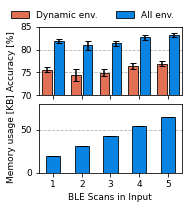

In [89]:
fig,ax = plt.subplots(2,1, figsize=(2.7,3), sharex=True)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

x_axis = (NUM_SCANS)*0.6

# Extract accuracy for dynamic environments
if cm_num_scans is not None:
    cm = cm_num_scans.copy()
    cm = np.max(cm,axis=-1)/1233
    dynenvs = np.zeros((5,10))
    # dynamic envs
    dynenvs[:,:] = (cm[:,:,0]+cm[:,:,1]+cm[:,:,3]+cm[:,:,4]+cm[:,:,6])/5

ax[0].bar(x_axis-0.125,
       np.nanmean(dynenvs,axis=-1)*100,
       yerr=np.nanstd(dynenvs,axis=-1)*100,
       width=0.2,
       capsize=3,
       linewidth=0.8,
       edgecolor='black',
       color='#e17055'
       )

ax[0].bar(x_axis+0.125,
       np.nanmean(accuracies_num_scans,axis=-1)*100,
       yerr=np.nanstd(accuracies_num_scans,axis=-1)*100,
       width=0.2,
       capsize=3,
       linewidth=0.8,
       edgecolor='black',
       color='#0984e3'
       )

ax[0].grid(axis='y',linestyle='dashed')
ax[0].axis([0,3,70,85])

ax[0].set_yticks([70,75,80,85])
ax[0].set_ylabel("Accuracy [%]")



ax[1].bar(x_axis,
       np.nanmean(sizes_num_scans,axis=-1)/1000,
       yerr=np.nanstd(sizes_num_scans,axis=-1)/1000,
       width=0.3,
       capsize=5,
       linewidth=0.8,
       edgecolor='black',
       color='#0984e3'
       )

ax[1].grid(axis='y',linestyle='dashed')
ax[1].axis([0.3,3.3,0,80])

#ax[1].set_yticks([75,77.5,80,82.5,85])
ax[1].set_xticks(x_axis)
ax[1].set_xticklabels(range(1,6))
ax[1].set_xlabel("BLE Scans in Input")

ax[1].set_ylabel("Memory usage [KB]")

ax[0].legend(['Dynamic env.', 'All env.'],
             bbox_to_anchor=(1, 1.35),
             loc="upper right",
             ncol=2,
             framealpha=0,
            )

plt.tight_layout()
plt.subplots_adjust(hspace=0.13)

matplotlib.rcParams.update({'font.size': 9})

plt.savefig('figures/num_scans_in_input.pdf', bbox_inches='tight', transparent=True)

In [91]:
cm = cm_num_scans.copy()
cm = np.max(cm,axis=-1)/1233*100

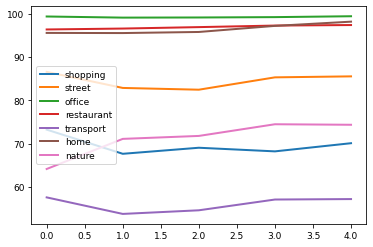

In [96]:
plt.plot(np.nanmean(cm,axis=1),linewidth=2)
plt.legend(labels)

In [99]:
for i in range(len(labels)):
    print(labels[i],np.nanmean(cm,axis=1)[:,i])

shopping [73.24412003 67.67234388 69.06731549 68.23195458 70.1135442 ]
street [86.56123277 82.85482563 82.44931062 85.29602595 85.52311436]
office [99.32684509 99.06731549 99.09975669 99.18085969 99.38361719]
restaurant [96.33414436 96.54501217 96.87753447 97.23438767 97.35604217]
transport [57.62368208 53.81184104 54.64720195 57.12895377 57.23438767]
home [95.53933496 95.50689376 95.75831306 97.16139497 98.13463098]
nature [64.16869424 71.11111111 71.79237632 74.48499594 74.36334144]


In [37]:
ddd[0,0]

array([76.80454177, 87.59124088, 99.35117599, 96.10705596, 55.87996756,
       95.53933496, 61.71938362])

In [29]:
labels

['shopping', 'street', 'office', 'restaurant', 'transport', 'home', 'nature']

# Eval: Different Neural Network Architecture

In [ ]:
architecture_to_test = [
    [100],
    [250],
    [500],
    [250,250],
    [500,500],
    [250,250,250],
]

In [ ]:
accuracies_arch = []
sizes_arch = []

prepared = prepare_datasets(train_set_path, test_set_path)
(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
features = prepared['features']

for arch in range(len(architecture_to_test)):
    accuracies_arch.append([])
    sizes_arch.append([])
    print(f"\n\nEvaluating architecture {architecture_to_test[arch]}")
    for model_it in range(10):
        tf.keras.backend.clear_session()
        print(f"Model {model_it}")
        # Create test split
        X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
        # Create and eval model
        model, acc, size = eval_model(X_train_split,
                                   Y_train_split,
                                   X_test,
                                   Y_test,
                                   X_eval,
                                   Y_eval,
                                   labels,
                                   feature_mean,
                                   feature_std,
                                   features,
                                   verbose=0,
                                   quantize_model=True,
                                   layers=architecture_to_test[arch],
                               )
        accuracies_arch[-1].append(acc)
        sizes_arch[-1].append(size)
accuracies_arch = np.array(accuracies_arch)

In [ ]:
x_axis[:2].shape

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(4,4.2),sharex=True)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)

tflm_extra_space = 5 #in KB

x_axis = (np.arange(len(architecture_to_test)+2)+1)*0.5


# decision tree
ax[0].bar(x_axis[0],
          np.nanmean([72.25,71.50,72.09,72.42,72.44,72.95,72.47,71.10,71.79,73.12]),
          yerr=np.nanstd([72.25,71.50,72.09,72.42,72.44,72.95,72.47,71.10,71.79,73.12]),
          width=0.3,
          capsize=5,
          linewidth=0.8,
          edgecolor='black',
          color='#55efc4'
       )
# random forest
ax[0].bar(x_axis[1],
          np.nanmean([79.42,79.78,79.34,78.72,79.59,79.24,79.67,78.89,79.37,79.52]),
          yerr=np.nanstd([79.42,79.78,79.34,78.72,79.59,79.24,79.67,78.89,79.37,79.52]),
          width=0.3,
          capsize=5,
          linewidth=0.8,
          edgecolor='black',
          color='#00b894',
          hatch='/',
       )

# BlueSeer
ax[0].bar(x_axis[2:],
       np.nanmean(accuracies_arch,axis=-1)*100,
       yerr=np.nanstd(accuracies_arch,axis=-1)*100,
       width=0.3,
       capsize=5,
       linewidth=0.8,
       edgecolor='black',
       color='#0984e3'
       )
# ax[0].bar(x_axis[4],
#        np.nanmean(accuracies_arch[2])*100,
#        yerr=np.nanstd(accuracies_arch[2])*100,
#        width=0.3,
#        capsize=5,
#        linewidth=1.5,
#        edgecolor='black',
#        color='#74b9ff'
#        )
ax[0].grid(axis='y',linestyle='dashed')
ax[0].axis([0.25,4.25,70,90])
ax[0].set_ylabel("Accuracy [%]")
ax[0].set_yticks([70,75,80,85,90])


# Memory usage

ax[1].bar(x_axis[0],
        15631.2/1000,
        width=0.3,
        capsize=5,
        linewidth=0.8,
        edgecolor='black',
        color='#55efc4'
       )
# random forest
ax[1].bar(x_axis[1],
        161360.8/1000,
        width=0.3,
        capsize=5,
        linewidth=0.8,
        edgecolor='black',
        color='#00b894',
        hatch='/',
       )

# BlueSeer
ax[1].bar(x_axis[2:],
       np.nanmean(sizes_arch,axis=-1)/1000 + tflm_extra_space,
       yerr=np.nanstd(sizes_arch,axis=-1)/1000,
       width=0.3,
       capsize=5,
       linewidth=0.8,
       edgecolor='black',
       color='#0984e3'
       )


# ax[1].bar(x_axis[4],
#        np.nanmean(sizes_arch[2])/1000 + tflm_extra_space,
#        yerr=np.nanstd(sizes_arch[2])/1000,
#        width=0.3,
#        capsize=5,
#        linewidth=1.5,
#        edgecolor='black',
#        color='#74b9ff'
#        )

ax[1].set_ylabel("Memory\n usage [KB]")
ax[0].legend(['Decision Tree', 'Random Forest', 'BlueSeer'],
             bbox_to_anchor=(1.1, 1.5),
             loc="upper right",
             ncol=2,
             framealpha=0,
            )
ax[1].grid(axis='y',linestyle='dashed')
ax[1].set_xticks(x_axis)
ax[1].set_yticks([0,100,200,300])
ax[1].set_xticklabels(['Tree','Forest','[100]','[250]',r'[500]',r'2$\times$[250]',r'2$\times$[500]',r'3$\times$[250]'],
                      rotation=25,
                      ha='right',
                     )
ax[1].set_xlabel("Network Architecture")

# rect = matplotlib.patches.Rectangle((2.25, 0), 0.5, 100,
#                          linewidth=2,
#                          edgecolor='r',
#                          facecolor='none')
# ax[0].add_patch(rect)

plt.tight_layout()
fig.subplots_adjust(hspace=0.08)

matplotlib.rcParams.update({'font.size': 11})

plt.savefig('figures/nn_archi_search.pdf', bbox_inches='tight', transparent=True)


In [ ]:
#np.save("accuracies_arch", accuracies_arch)
#np.save("sizes_arch", sizes_arch)

In [ ]:
# accuracies_arch = np.load("numpy_data/accuracies_arch.npy")
# sizes_arch = np.load("numpy_data/sizes_arch.npy")

In [ ]:
np.nanmean(sizes_arch, axis=1)

In [ ]:
#  model, acc = eval_model(X_train_split,
#                                    Y_train_split,
#                                    X_test,
#                                    Y_test,
#                                    X_eval,
#                                    Y_eval,
#                                    labels,
#                                    feature_mean,
#                                    feature_std,
#                                    features,
#                                    verbose=1,
#                                    quantize_model=False,
#                                    layers=[500],)

# SKlearn decision tree

In [ ]:
prepared = prepare_datasets(train_set_path, test_set_path)
(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
features = prepared['features']

In [ ]:
from sklearn.tree import DecisionTreeClassifier

accuracies_dt = []
sizes_dt = []

for i in range(10):
    (X_train,Y_train) = prepared['training']
    (X_eval, Y_eval) = prepared['eval']
    # Create test split
    X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
    dt_model = DecisionTreeClassifier()
    dt_model.fit(X_train_split,Y_train_split)
    pred = dt_model.predict(X_eval)
    print(f"Tree model {i}: {np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100:.2f}")
    accuracies_dt.append(np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100)
    size = dt_model.tree_.node_count
    sizes_dt.append(size)
accuracy_dt = np.nanmean(accuracies_dt)
print(f"avg: {accuracy_dt:.2f}%")
print(f"size: {np.nanmean(sizes_dt)*4}")

In [ ]:
def print_tree(dt_model, features):
    features = [[f"{p}_{i}" for p in features] for i in range(5)]
    features = [item for sublist in features for item in sublist]
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_model,
                               feature_names=features,
                               class_names=labels,
                               filled=True)

# Random Forest

In [ ]:
accuracies_dt = []
sizes_dt = []

for i in range(10):
    (X_train,Y_train) = prepared['training']
    (X_eval, Y_eval) = prepared['eval']
    # Create test split
    X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
    dt_model = RandomForestClassifier(n_estimators=10)
    dt_model.fit(X_train_split,Y_train_split)
    pred = dt_model.predict(X_eval)
    print(f"Forest model {i}: {np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100:.2f}")
    accuracies_dt.append(np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100)
    size = 0
    for tree in dt_model.estimators_:
        size += tree.tree_.node_count*4
    sizes_dt.append(size)
accuracy_dt = np.nanmean(accuracies_dt)
print(f"avg: {accuracy_dt:.2f}%")
print(f"size: {np.nanmean(sizes_dt)}")

In [ ]:
np.nanmean(sizes_dt)

# Confusion Matrix

In [ ]:
cm = confusion_matrix(Y_eval, np.argmax(best_model.predict(X_eval),axis=1))
print(cm)
max_v = np.sum(cm[0])
cm = pd.DataFrame(cm, index = [lbl.capitalize() for lbl in labels],
                  columns = [lbl.capitalize() for lbl in labels])

In [ ]:
plt.figure(figsize = (4,4))
ax = sn.heatmap(cm/max_v*100,
           annot=True,
           fmt='.1f',
           cmap="Blues",
           cbar=False,
              )
ax.set_ylabel("True Class", fontdict= {'fontweight':'bold'})
ax.set_xlabel("Predicted Class", fontdict= {'fontweight':'bold'})

plt.tight_layout()
matplotlib.rcParams.update({'font.size': 10})

plt.savefig('figures/confusion_matrix.pdf', bbox_inches='tight', transparent=True)

In [ ]:
np.sum(np.equal(Y_eval,np.argmax(best_model.predict(X_eval),axis=1)))/len(Y_eval)

In [ ]:
np.sum(cm[:,0])

In [ ]:
labels

# Feature analysis

In [ ]:
prepared = prepare_datasets(train_set_path, test_set_path)
(X_train,Y_train) = prepared['training']
(X_eval, Y_eval) = prepared['eval']
labels = prepared['labels']
feature_mean = prepared['feature_mean']
feature_std = prepared['feature_std']
features = prepared['features']

In [ ]:
accuracies_feature = []


selected_ft = [[" device_count"," lost_devices"," new_devices",],
               [" different_services"," services_count"," man_packet_len_count", " manufacturer_data_lengths_sum", " manufacturer_data_len_avg"],
               [" txpower_count"," tx_power_avg"," min_txpower"," max_txpower"],
               [" avg_received", " min_received", " max_received"],
               [" avg_avg_rssi"," min_avg_rssi"," max_avg_rssi"," min_rssi"," max_rssi"," avg_rssi_difference"]]


X_train = keep_n_scans(X_train, num_scans=1)
X_eval = keep_n_scans(X_eval, num_scans=1)

# Baseline
print("Baseline")
accuracies_feature.append([])
for model_it in range(10):
        # Create test split
        X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
        # remove feature
        # Create and eval model
        model, acc,_ = eval_model(X_train_split,
                                Y_train_split,
                                X_test,
                                Y_test,
                                X_eval,
                                Y_eval,
                                labels,
                                feature_mean,
                                feature_std,
                                features,
                                verbose=0,
                                quantize_model=False,
                               )
        accuracies_feature[-1].append(acc)

for ft in selected_ft:
    print(f"Removing:{ft}")
    accuracies_feature.append([])
    for model_it in range(10):
        # Create test split
        X_train_split, X_test, Y_train_split, Y_test = train_test_split(X_train,Y_train,test_size=0.1)
        # remove feature
        X_train_ = remove_features(X_train_split,features,ft)
        X_test_ = remove_features(X_test,features,ft)
        X_eval_ = remove_features(X_eval,features,ft)
        # Create and eval model
        model, acc,_ = eval_model(X_train_,
                                Y_train_split,
                                X_test_,
                                Y_test,
                                X_eval_,
                                Y_eval,
                                labels,
                                feature_mean,
                                feature_std,
                                features,
                                verbose=0,
                                quantize_model=False,
                               )
        accuracies_feature[-1].append(acc)

accuracies_feature = np.array(accuracies_feature)


In [ ]:
fts = ['All features',
       'w/o Nb. Devices',
       'w/o Nb. Services',
       'w/o TX Power',
       'w/o Nb. Adv. ',
       'w/o RSS',
      ]


fig,ax = plt.subplots(1,1, figsize=(6,3),) # sharex=True
ax.set_axisbelow(True)

ax.plot([-5,30],
        [81.5340054]*2,
        zorder=-1,
        linestyle='--',
        linewidth=2,
        color='#0984e3'
       )


ax.bar(np.arange(accuracies_feature.shape[0]),
       np.nanmean(accuracies_feature,axis=1)*100,
       yerr=np.nanstd(accuracies_feature,axis=1)*100,
       width=0.5,
       capsize=5,
       linewidth=0.8,
       edgecolor='black',
       color='#0984e3')


ax.set_ylabel("Accuracy [%]")
ax.grid(axis='y',linestyle='dashed')
ax.set_xticks(np.arange(accuracies_feature.shape[0]))
ax.set_xticklabels(fts,
                   rotation=35,
                   ha='right')
ax.set_yticks([70,75,80,85,90])
ax.axis([-0.5,5.5,70,90])

plt.tight_layout()
matplotlib.rcParams.update({'font.size': 10})

#plt.savefig('figures/feature_analysis.pdf', bbox_inches='tight', transparent=True)

In [ ]:
np.nanmean(accuracies_feature,axis=1)*100

In [ ]:
np.unique(Y_eval)

In [ ]:
#np.save("acc_feature_analysis", accuracies_feature)

In [ ]:
#accuracies_feature = np.load("numpy_data/acc_feature_analysis.npy")

In [ ]:
interesting_features = np.array([0,1,2,3,4,5,6,7,14,15,22])
for i in interesting_features:
    print(features[i])

# SKLearn Feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

dd = SelectKBest(f_classif, k=50)
X_new = dd.fit_transform(X_train, Y_train)
Xe_new = dd.transform(X_eval)

In [ ]:
for idx in dd.get_support(True):
    scan_idx = idx//23
    ft = idx%23
    print(f"{features[ft]}, scan {scan_idx}")

In [ ]:
d1, d2 = f_classif(X_train, Y_train)

In [ ]:
plt.plot(d1[:23])
i = 0
for ft in features:
    print(f"{i}: {ft}, {d1[i]}")
    i+=1

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_new,Y_train)
pred = dt_model.predict(Xe_new)
print(f"Tree model {i}: {np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100:.2f}")

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,Y_train)
pred = dt_model.predict(X_eval)
print(f"Tree model {i}: {np.sum(np.equal(pred,Y_eval))/pred.shape[0]*100:.2f}")

In [ ]:
inpt = [[32,3,0,2,3,61,16,5,246,238,116,15,12,1,31,-70,-88,-33,-91,-32,6,7425,63618,
         35,0,4,2,5,56,25,5,246,230,116,15,11,1,27,-71,-89,-33,-89,-32,6,6042,58696,
         31,1,3,2,5,56,12,5,246,226,134,15,12,1,31,-69,-87,-34,-87,-33,6,8416,68209,
         29,2,4,3,6,64,23,5,246,224,116,15,13,1,32,-69,-90,-34,-90,-32,7,9586,71786,
         27,6,2,2,3,54,21,5,246,231,116,15,14,1,30,-67,-85,-34,-86,-34,6,9894,76912,]]
inpt,_ = normalize_data(inpt,["office"],feature_mean,feature_std,labels)

In [ ]:
print(labels)

In [ ]:
best_model.predict(inpt)